# Redes Neuronales en Finanzas

In [61]:
import pandas as pd
import numpy as np
import sklearn 
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA

#import statsmodels
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

### Carga y Exploración de Datos

Fuente de datos: https://finance.yahoo.com/quote/BX/history?p=BX

In [8]:
DataBX = pd.read_csv('BX.csv')

In [63]:
DataBX.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2019-11-06,52.500000,52.560001,51.310001,52.040001,52.040001,6270100
247,2019-11-07,52.639999,52.939999,51.380001,51.400002,51.400002,7323000
248,2019-11-08,51.220001,51.910000,51.200001,51.529999,51.529999,5158600
249,2019-11-11,51.529999,52.040001,51.349998,51.910000,51.910000,3059700
250,2019-11-12,51.990002,52.119999,51.310001,51.959999,51.959999,3548835


In [64]:
DataBX.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [11]:
DataBX['Date'] = pd.to_datetime(DataBX.Date)

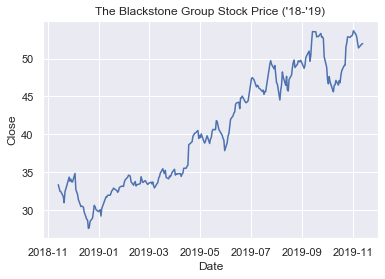

In [66]:
sns.set()
sns.lineplot(DataBX['Date'], DataBX.Close)
#plt.plot(DataBX['Date'], DataBX.Close)
plt.title("The Blackstone Group Stock Price ('18-'19)")
plt.show()

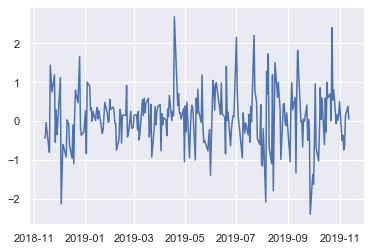

In [67]:
plt.plot(DataBX.Date, DataBX['Close'].diff())

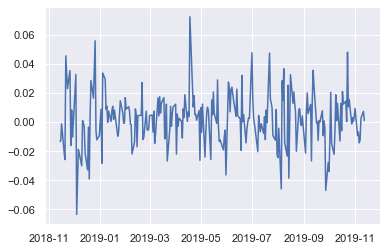

In [70]:
plt.plot(DataBX.Date, np.log(DataBX['Close']).diff())

In [71]:
def ACF(s):
    acfs = {}
    for i in range(20):
        acfs[i]=s.autocorr(lag=i)
        #print(s.autocorr(lag=i))
    return acfs

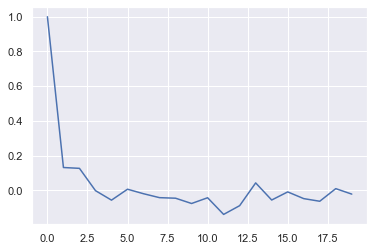

In [73]:
acorr = ACF(DataBX['Close'].diff())

list(acorr.keys()), list(acorr.values())

sns.lineplot(list(acorr.keys()), list(acorr.values()))

# Pronosticando con ARIMA

ARIMA significa Autoregresive Integrated Moving Average. 

Es un modelo que se compone de tres partes: 
* Autoregresión: El modelo ajusta una regresión de la serie a predecir sobre si misma. Toma en cuenta hasta p lags. 
* Integrado: El modelo hace una diferenciacion para convertir a la serie de tiempo en estacionaria.
* Ventana Movil ( Moving Avegare): Usa la dependencia entre las obersaciones y el error residual de un modelo de media movil.


Los parametros principales del modelo son:
* p el número de lags observados,
* d el numero de diferenciaciones del modelo.
* q es el número de periodos usados para la ventana movil. 

Primero usamos las Autocorrelaciones para determinar cual es el mejor parámetro para el número de lags en la autoregresión, es decir para determinar **p**.

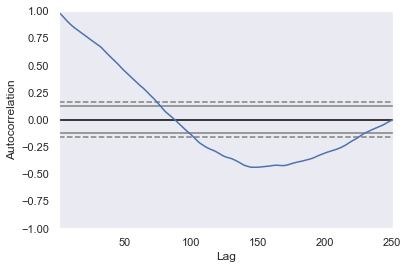

In [74]:
autocorrelation_plot(np.log(DataBX['Close']))

predicted=46.048283, expected=45.660000
predicted=45.695652, expected=45.830002
predicted=45.885835, expected=45.279999
predicted=45.325706, expected=45.650002
predicted=45.692026, expected=45.630001
predicted=45.740365, expected=47.840000
predicted=48.100299, expected=48.599998
predicted=49.042361, expected=49.240002
predicted=49.403909, expected=49.720001
predicted=49.792172, expected=49.259998
predicted=49.253114, expected=48.650002
predicted=48.513220, expected=49.070000
predicted=49.066286, expected=47.980000
predicted=48.054357, expected=46.820000
predicted=46.678704, expected=46.619999
predicted=46.514681, expected=44.529999
predicted=44.385610, expected=45.810001
predicted=45.745919, expected=46.500000
predicted=46.876425, expected=48.230000
predicted=48.805252, expected=47.560001
predicted=47.818717, expected=46.459999
predicted=46.134429, expected=47.650002
predicted=47.538486, expected=45.849998
predicted=46.124581, expected=45.720001
predicted=45.639731, expected=47.230000


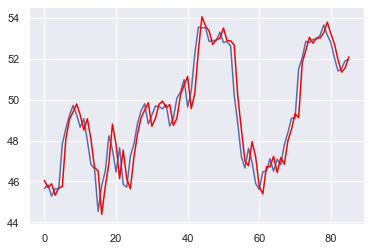

In [76]:

X = DataBX['Close'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test MSE: 0.790


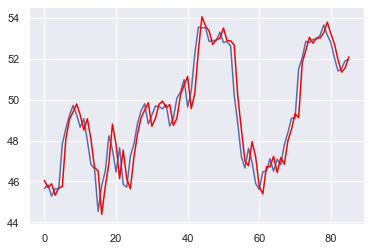

In [77]:
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Prediciendo con LSTMs

In [80]:
# Importando las librerías necesarias.

import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

## Redes Neuronales Recurrentes

<img src='https://miro.medium.com/max/627/1*go8PHsPNbbV6qRiwpUQ5BQ.png'>

<img src='https://miro.medium.com/max/357/0*04-4nua4q2PRqLag.png'>

### LSTMs

<img src='https://miro.medium.com/max/1044/1*MwU5yk8f9d6IcLybvGgNxA.jpeg'>

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1'>

Antes de poder usar la serie de tiempo para predecir datos tenemos que transformarla en información que la Red Neuronal pueda entender. 

Esto significa crear un conjunto de datos de entrenamiento y su respectiva variable objetiva.

In [30]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]

data = pd.DataFrame(X, columns=['x_t-2', 'x_t-1', 'x_t'])
pd.DataFrame(y)
pd.concat([data, pd.DataFrame(y, columns=['x_t+1'])], axis=1)

,x_t-2,x_t-1,x_t,x_t+1
0,10,20,30,40
1,20,30,40,50
2,30,40,50,60
3,40,50,60,70
4,50,60,70,80
5,60,70,80,90


In [6]:
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.00388]]


In [120]:
# define input sequence
raw_seq = DataBX.Close.to_list()[:int(len(DataBX.Close.to_list())/3*2)]
#print(raw_seq)
# choose a number of time steps
n_steps = 2
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]

#data = pd.DataFrame(X, columns=['x_t-2', 'x_t-1', 'x_t'])
#dataset = pd.concat([data, pd.DataFrame(y, columns=['x_t+1'])], axis=1)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

#dataset.head()

In [121]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [122]:
# fit model
model.fit(X, y, epochs=200, verbose=0)


In [123]:
# demonstrate prediction
x_input = array([70, 80])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[74.02607]]


In [125]:
raw_test = DataBX.Close.to_list()[int(len(DataBX.Close.to_list())/3*2):]

n_steps = 2
# split into samples
X_test, y_test = split_sequence(raw_test, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1
X = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))


In [127]:
y_pred = []
for obs in X_test:
    #print(obs)
    x_input = array(obs)
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    y_pred.append(float(yhat))
    

In [128]:
error = mean_squared_error(y_test, y_pred)

print('Test MSE: %.3f' % error)

Test MSE: 1.261


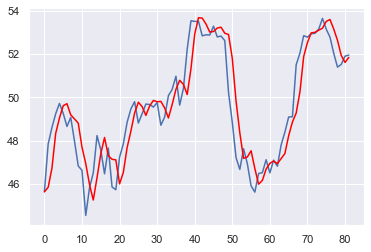

In [129]:
plt.plot(y_test)
plt.plot(y_pred, color='red')
plt.show()